In [ ]:
# Initilization

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import pickle
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import numpy as np
import random
import seaborn as sns
from sklearn import metrics
from torchvision.models import resnet18
import kagglehub
import os
from PIL import Image
import cv2
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mounting google drive:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/DL_Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ensuring same random is used for all types of data:

In [ ]:
num = random.random()
random.seed(num)

In [ ]:
sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [ ]:
# Custom Dataset for Raw images
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (list): List of image arrays (NumPy or PIL).
            labels (list): List of corresponding labels.
            transform (callable, optional): Optional transform to apply to the images.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label


# Loading data

Clip Data:

Face data:

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/DL_Project/'
with open(path + '/NVIDIA_Faces_CLIP_embeddings/NVIDIA_CLIP_train_real_embedded_pickle.pickle', 'rb') as f:
     train_real_embeddings_face = pickle.load(f)

with open(path + '/NVIDIA_Faces_CLIP_embeddings/NVIDIA_CLIP_train_fake_embedded_pickle.pickle', 'rb') as f:
     train_fake_embeddings_face = pickle.load(f)

with open(path + '/NVIDIA_Faces_CLIP_embeddings/NVIDIA_CLIP_test_real_embedded_pickle.pickle', 'rb') as f:
     test_real_embeddings_face = pickle.load(f)

with open(path + '/NVIDIA_Faces_CLIP_embeddings/NVIDIA_CLIP_test_fake_embedded_pickle.pickle', 'rb') as f:
     test_fake_embeddings_face = pickle.load(f)

In [ ]:
# Assuming the embeddings are numpy arrays
# Concatenate train and test real embeddings
real_embeddings_face = np.concatenate([train_real_embeddings_face, test_real_embeddings_face], axis=0)

# Concatenate train and test fake embeddings
synthetic_embeddings_face = np.concatenate([train_fake_embeddings_face, test_fake_embeddings_face], axis=0)

# Print the shapes of the combined datasets for verification
print(f"Shape of real_embeddings: {real_embeddings_face.shape}")
print(f"Shape of fake_embeddings: {synthetic_embeddings_face.shape}")


Shape of real_embeddings: (70000, 512)
Shape of fake_embeddings: (70000, 512)


In [ ]:
len(real_embeddings_face)

70000

CIFAKE

In [ ]:
with open(path + '/CIFAKE_CLIP_embeddings/CIFAKE_CLIP_train_real_embedded_pickle.pickle', 'rb') as f:
     train_real_embeddings_cifake = pickle.load(f)

with open(path + '/CIFAKE_CLIP_embeddings/CIFAKE_CLIP_train_fake_embedded_pickle.pickle', 'rb') as f:
     train_fake_embeddings_cifake = pickle.load(f)

with open(path + '/CIFAKE_CLIP_embeddings/CIFAKE_CLIP_test_real_embedded_pickle.pickle', 'rb') as f:
     test_real_embeddings_cifake = pickle.load(f)

with open(path + '/CIFAKE_CLIP_embeddings/CIFAKE_CLIP_test_fake_embedded_pickle.pickle', 'rb') as f:
     test_fake_embeddings_cifake = pickle.load(f)

In [ ]:
real_embeddings_cifake = np.concatenate([train_real_embeddings_cifake, test_real_embeddings_cifake], axis=0)

# Concatenate train and test fake embeddings
synthetic_embeddings_cifake = np.concatenate([train_fake_embeddings_cifake, test_fake_embeddings_cifake], axis=0)

print(f"Shape of real_embeddings: {real_embeddings_cifake.shape}")
print(f"Shape of fake_embeddings: {synthetic_embeddings_cifake.shape}")

Shape of real_embeddings: (60000, 512)
Shape of fake_embeddings: (60000, 512)


Cars:

In [ ]:
 # Load the data from a pickle file of real images
with open(path + '/standford_cars_real_CLIP_embedded_pickle.pickle', 'rb') as f:
     real_embeddings_cars = pickle.load(f)

 # Load the data from a pickle file of synthtic images
with open(path + '/standford_cars_synthetic_CLIP_embedded_pickle.pickle', 'rb') as f:
     synthetic_embeddings_cars = pickle.load(f)

Raw data:

face:

In [ ]:
def get_image_paths(data_path):
    """Retrieve paths to all images in a directory."""
    image_paths = []
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [ ]:
# Download latest version
path_face = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")

print("Path to dataset files:", path_face)

Path to dataset files: /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2


In [ ]:
train_real_path_face = os.path.join(path_face, "real_vs_fake/real-vs-fake/train/real")
train_fake_path_face = os.path.join(path_face, "real_vs_fake/real-vs-fake/train/fake")
val_real_path_face = os.path.join(path_face, "real_vs_fake/real-vs-fake/valid/real")
val_fake_path_face = os.path.join(path_face, "real_vs_fake/real-vs-fake/valid/fake")
test_real_path_face = os.path.join(path_face, "real_vs_fake/real-vs-fake/test/real")
test_fake_path_face = os.path.join(path_face, "real_vs_fake/real-vs-fake/test/fake")

In [ ]:
train_real_images_face = get_image_paths(train_real_path_face)
train_fake_images_face = get_image_paths(train_fake_path_face)
test_real_images_face = get_image_paths(test_real_path_face)
test_fake_images_face = get_image_paths(test_fake_path_face)
val_real_images_face = get_image_paths(val_real_path_face)
val_fake_images_face = get_image_paths(val_fake_path_face)

In [ ]:
# Combine train and test image paths
real_image_paths_face = train_real_images_face + test_real_images_face
synthetic_image_paths_face = train_fake_images_face + test_fake_images_face


sample_size = 4000
indices_real_face = random.sample(range(len(real_image_paths_face)), sample_size)
indices_synthetic_face = random.sample(range(len(real_image_paths_face)), sample_size)


real_image_paths_face = [real_image_paths_face[i] for i in indices_real_face]

synthetic_image_paths_face = [synthetic_image_paths_face[i] for i in indices_synthetic_face]


def load_images(image_paths):
    """
    Load images from a list of paths and convert them to numpy arrays.
    """
    images = []
    for path in image_paths:
        try:
            with Image.open(path) as img:
                img = img.convert('RGB')
                images.append(np.array(img))
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return images


# Create the datasets
real_images_raw_face = load_images(real_image_paths_face)
synthetic_images_raw_face = load_images(synthetic_image_paths_face)

print(f"Loaded {len(real_images_raw_face)} real images.")
print(f"Loaded {len(synthetic_images_raw_face)} synthetic images.")

Loaded 4000 real images.
Loaded 4000 synthetic images.


In [ ]:
real_embeddings_face = [real_embeddings_face[i] for i in indices_real_face]
synthetic_embeddings_face = [synthetic_embeddings_face[i] for i in indices_real_face]

CIFAKE:

In [ ]:
# Download latest version
path_cifake = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path_cifake)

Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [ ]:
train_real_path_cifake = os.path.join(path_cifake, "train/REAL")
train_fake_path_cifake = os.path.join(path_cifake, "train/FAKE")
test_real_path_cifake = os.path.join(path_cifake, "test/REAL")
test_fake_path_cifake = os.path.join(path_cifake, "test/FAKE")

In [ ]:
train_real_images_cifake = get_image_paths(train_real_path_cifake)
train_fake_images_cifake = get_image_paths(train_fake_path_cifake)
test_real_images_cifake = get_image_paths(test_real_path_cifake)
test_fake_images_cifake = get_image_paths(test_fake_path_cifake)

In [ ]:
# Combine train and test image paths
real_image_paths_cifake = train_real_images_cifake + test_real_images_cifake
synthetic_image_paths_cifake = train_fake_images_cifake + test_fake_images_cifake


sample_size = 2000
indices_real_cifake = random.sample(range(len(real_image_paths_cifake)), sample_size)
indices_synthetic_cifake = random.sample(range(len(real_image_paths_cifake)), sample_size)

real_image_paths_cifake = [real_image_paths_cifake[i] for i in indices_real_cifake]

synthetic_image_paths_cifake = [synthetic_image_paths_cifake[i] for i in indices_synthetic_cifake]

# Create the datasets
real_images_raw_cifake = load_images(real_image_paths_cifake)
synthetic_images_raw_cifake = load_images(synthetic_image_paths_cifake)

print(f"Loaded {len(real_images_raw_cifake)} real images.")
print(f"Loaded {len(synthetic_images_raw_cifake)} synthetic images.")

Loaded 2000 real images.
Loaded 2000 synthetic images.


In [ ]:
real_embeddings_cifake = [real_embeddings_cifake[i] for i in indices_real_cifake]
synthetic_embeddings_cifake = [synthetic_embeddings_cifake[i] for i in indices_synthetic_cifake]

Cars:

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/DL_Project/'
with open(path + '/standford_cars_real_preprocessed_pickle.pickle', 'rb') as f:
     real_images_raw_cars = pickle.load(f)

path = '/content/drive/MyDrive/Colab Notebooks/DL_Project/'
with open(path + '/standford_cars_synthetic_preprocessed_pickle.pickle', 'rb') as f:
     synthetic_images_raw_cars = pickle.load(f)

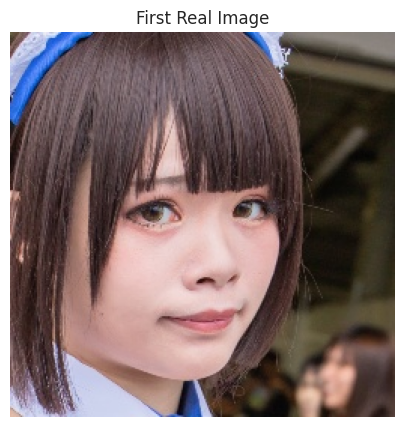

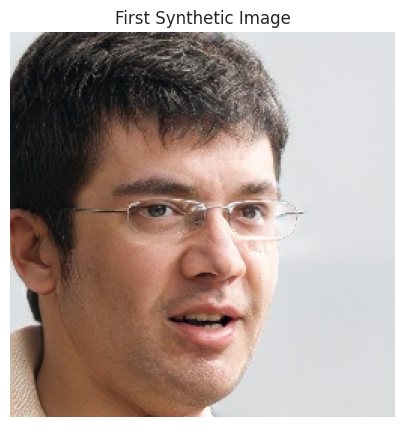

In [ ]:
# Display the first image in the real_images_raw dataset
def display_image(image_array, title="Image"):
    """
    Display a single image using matplotlib.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(image_array)
    plt.title(title)
    plt.axis('off')  # Hide the axes for clarity
    plt.show()

if real_images_raw_face:
    display_image(real_images_raw_face[0], title="First Real Image")
else:
    print("No real images loaded.")

if synthetic_images_raw_face:
    display_image(synthetic_images_raw_face[0], title="First Synthetic Image")
else:
    print("No synthetic images loaded.")

Spectral data:

Face:

In [ ]:
def resize_and_crop(image, smallest_side):
  height, width, num_channels = image.shape

  # Resize.
  if height <= width:
    new_height = smallest_side
    new_width = int(width * (new_height / height))
  else:
    new_width = smallest_side
    new_height = int(height * (new_width / width))

  image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

  # Centre crop.
  offset_h = (new_height - smallest_side) // 2
  offset_w = (new_width - smallest_side) // 2

  return image[offset_h:offset_h + smallest_side, offset_w:offset_w + smallest_side, :]

In [ ]:
image_size = 224
num_examples = len(real_images_raw_face)
real_images_spec_face = []
for i in range(num_examples):

    example = real_images_raw_face[i]
    arr = resize_and_crop(example, image_size)
    real_images_spec_face.append(arr)

# Convert the list of images to a NumPy array
real_images_spec_face = np.array(real_images_spec_face)

In [ ]:
image_size = 224
num_examples = len(synthetic_images_raw_face)
synthetic_images_spec_face = []
for i in range(num_examples):

    example = synthetic_images_raw_face[i]
    arr = resize_and_crop(example, image_size)
    synthetic_images_spec_face.append(arr)

# Convert the list of images to a NumPy array
synthetic_images_spec_face = np.array(synthetic_images_spec_face)

In [ ]:
num_images = len(real_images_spec_face)
spec_all_real_face = []
spec = []
for i in range(num_images):

    spec = np.fft.fft2(real_images_spec_face[i][:, :, 1])
    spec = np.fft.fftshift(spec)
    spec = np.array(spec)
    spec = np.abs(spec)
    spec = np.log(spec)
    spec_all_real_face.append(spec)

real_images_spec_face = spec_all_real_face

In [ ]:
num_images = len(synthetic_images_spec_face)
spec_all_synthetic_face = []
spec= []
for i in range(num_images):

    spec = np.fft.fft2(synthetic_images_spec_face[i][:, :, 1])
    spec = np.fft.fftshift(spec)
    spec = np.array(spec)
    spec = np.abs(spec)
    spec = np.log(spec)
    spec_all_synthetic_face.append(spec)

synthetic_images_spec_face = spec_all_synthetic_face

CIFAKE:

In [ ]:
image_size = 224
num_examples = len(real_images_raw_cifake)
real_images_spec_cifake = []
for i in range(num_examples):

    example = real_images_raw_cifake[i]
    arr = resize_and_crop(example, image_size)
    real_images_spec_cifake.append(arr)

# Convert the list of images to a NumPy array
real_images_spec_cifake = np.array(real_images_spec_cifake)

In [ ]:
image_size = 224
num_examples = len(synthetic_images_raw_cifake)
synthetic_images_spec_cifake = []
for i in range(num_examples):

    example = synthetic_images_raw_cifake[i]
    arr = resize_and_crop(example, image_size)
    synthetic_images_spec_cifake.append(arr)

# Convert the list of images to a NumPy array
synthetic_images_spec_cifake = np.array(synthetic_images_spec_cifake)

In [ ]:
num_images = len(real_images_spec_cifake)
spec_all_real_cifake = []
spec = []
for i in range(num_images):

    spec = np.fft.fft2(real_images_spec_cifake[i][:, :, 1])
    spec = np.fft.fftshift(spec)
    spec = np.array(spec)
    spec = np.abs(spec)
    spec = np.log(spec)
    spec_all_real_cifake.append(spec)

real_images_spec_cifake = spec_all_real_cifake

In [ ]:
num_images = len(synthetic_images_spec_cifake)
spec_all_synthetic_cifake = []
spec= []
for i in range(num_images):

    spec = np.fft.fft2(synthetic_images_spec_cifake[i][:, :, 1])
    spec = np.fft.fftshift(spec)
    spec = np.array(spec)
    spec = np.abs(spec)
    spec = np.log(spec)
    spec_all_synthetic_cifake.append(spec)

synthetic_images_spec_cifake = spec_all_synthetic_cifake

Cars:

In [ ]:
 # Load the data from a pickle file of real images

path_cars = '/content/drive/MyDrive/Colab Notebooks/DL_Project/'
with open(path_cars + '/standford_cars_real_spec_pickle.pickle', 'rb') as f:
     real_images_spec_cars = pickle.load(f)

 # Load the data from a pickle file of synthetic images

path_cars = '/content/drive/MyDrive/Colab Notebooks/DL_Project/'
with open(path_cars + '/standford_cars_synthetic_spec_pickle.pickle', 'rb') as f:
     synthetic_images_spec_cars = pickle.load(f)

# Making sure that both classes are of same size for car data

In [ ]:

real_embeddings_type = type(real_embeddings_cars)
synthetic_embeddings_type = type(synthetic_embeddings_cars)

# Convert tensors to lists or numpy arrays for processing
real_images_spec_cars = list(real_images_spec_cars)
real_images_raw_cars = list(real_images_raw_cars)
real_embeddings_cars = real_embeddings_cars.tolist()

synthetic_images_spec_cars = list(synthetic_images_spec_cars)
synthetic_images_raw_cars = list(synthetic_images_raw_cars)
synthetic_embeddings_cars = synthetic_embeddings_cars.tolist()

real_count = len(real_images_spec_cars)
synthetic_count = len(synthetic_images_spec_cars)
embedding_count = len(real_embeddings_cars)


min_count = min(real_count, synthetic_count, embedding_count)


if real_count > synthetic_count:
    real_images_spec_cars = random.sample(real_images_spec_cars, min_count)
    real_images_raw_cars = random.sample(real_images_raw_cars, min_count)
    real_embeddings_cars = random.sample(real_embeddings_cars, min_count)
else:
    synthetic_images_spec_cars = random.sample(synthetic_images_spec_cars, min_count)
    synthetic_images_raw_cars = random.sample(synthetic_images_raw_cars, min_count)
    synthetic_embeddings_cars = random.sample(synthetic_embeddings_cars, min_count)


real_embeddings_cars = torch.tensor(real_embeddings_cars)
synthetic_embeddings_cars = torch.tensor(synthetic_embeddings_cars)


# Output the balanced data
print("Data balancing complete!")

Data balancing complete!


# Concatenating all data types:

Clip

In [ ]:
real_embeddings = np.concatenate([real_embeddings_face, real_embeddings_cifake, real_embeddings_cars], axis=0)
synthetic_embeddings = np.concatenate([synthetic_embeddings_face, synthetic_embeddings_cifake, synthetic_embeddings_cars], axis=0)

Raw:

In [ ]:
def resize_and_crop(image, smallest_side):
    # Ensure the image has 3 dimensions
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError(f"Image does not have 3 channels: shape {image.shape}")

    height, width, num_channels = image.shape

    # Resize
    if height <= width:
        new_height = smallest_side
        new_width = int(width * (new_height / height))
    else:
        new_width = smallest_side
        new_height = int(height * (new_width / width))

    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # Center crop
    offset_h = (new_height - smallest_side) // 2
    offset_w = (new_width - smallest_side) // 2

    return image[offset_h:offset_h + smallest_side, offset_w:offset_w + smallest_side, :]

image_size = 224  # Target size for resizing and cropping

# Process real_images_raw_face
processed_real_images_raw_face = []
for i in range(len(real_images_raw_face)):
    processed_real_images_raw_face.append(resize_and_crop(real_images_raw_face[i], image_size))
processed_real_images_raw_face = np.array(processed_real_images_raw_face)

# Process synthetic_images_raw_face
processed_synthetic_images_raw_face = []
for i in range(len(synthetic_images_raw_face)):
    processed_synthetic_images_raw_face.append(resize_and_crop(synthetic_images_raw_face[i], image_size))
processed_synthetic_images_raw_face = np.array(processed_synthetic_images_raw_face)

# Process real_images_raw_cifake
processed_real_images_raw_cifake = []
for i in range(len(real_images_raw_cifake)):
    processed_real_images_raw_cifake.append(resize_and_crop(real_images_raw_cifake[i], image_size))
processed_real_images_raw_cifake = np.array(processed_real_images_raw_cifake)

# Process synthetic_images_raw_cifake
processed_synthetic_images_raw_cifake = []
for i in range(len(synthetic_images_raw_cifake)):
    processed_synthetic_images_raw_cifake.append(resize_and_crop(synthetic_images_raw_cifake[i], image_size))
processed_synthetic_images_raw_cifake = np.array(processed_synthetic_images_raw_cifake)

# Process real_images_raw_cars
processed_real_images_raw_cars = []
for i in range(len(real_images_raw_cars)):
    processed_real_images_raw_cars.append(resize_and_crop(real_images_raw_cars[i], image_size))
processed_real_images_raw_cars = np.array(processed_real_images_raw_cars)

# Process synthetic_images_raw_cars
processed_synthetic_images_raw_cars = []
for i in range(len(synthetic_images_raw_cars)):
    processed_synthetic_images_raw_cars.append(resize_and_crop(synthetic_images_raw_cars[i], image_size))
processed_synthetic_images_raw_cars = np.array(processed_synthetic_images_raw_cars)

# Combine processed datasets
real_images_raw = np.concatenate(
    [processed_real_images_raw_face, processed_real_images_raw_cifake, processed_real_images_raw_cars], axis=0
)
synthetic_images_raw = np.concatenate(
    [processed_synthetic_images_raw_face, processed_synthetic_images_raw_cifake, processed_synthetic_images_raw_cars],
    axis=0
)

# Verify final shapes
print(f"Shape of real_images_raw: {real_images_raw.shape}")
print(f"Shape of synthetic_images_raw: {synthetic_images_raw.shape}")


Shape of real_images_raw: (9120, 224, 224, 3)
Shape of synthetic_images_raw: (9120, 224, 224, 3)


In [ ]:
# Check for images without 3 channels
invalid_indices = []

for i, img in enumerate(real_images_raw_face):
    if len(img.shape) != 3 or img.shape[2] != 3:
        invalid_indices.append(i)

# Output the indices of invalid images
if invalid_indices:
    print(f"Indices of images without 3 channels: {invalid_indices}")
else:
    print("All images have 3 channels.")


All images have 3 channels.


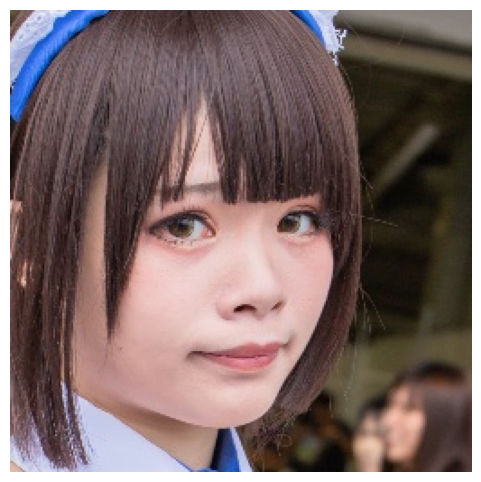

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(real_images_raw_face[0], vmin=-5, vmax=11)
plt.axis('off')
plt.show()

Spec:

In [ ]:
real_images_spec = np.concatenate([real_images_spec_face, real_images_spec_cifake, real_images_spec_cars], axis=0)
synthetic_images_spec = np.concatenate([synthetic_images_spec_face, synthetic_images_spec_cifake, synthetic_images_spec_cars], axis=0)

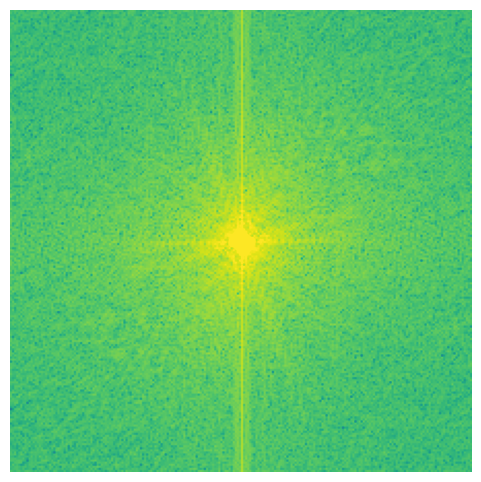

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(real_images_spec[100], vmin=-5, vmax=11, cmap=plt.cm.viridis)
plt.axis('off')
plt.show()

# Creating Training and test datasets:

Setting random seed for split of data:

In [ ]:
random_state = 42

Spec Images:

In [ ]:
real_labels_spec = [1] * len(real_images_spec)  # Label 1 for real images
synthetic_labels_spec = [0] * len(synthetic_images_spec)  # Label 0 for synthetic images

In [ ]:
# Combine images and labels
all_images_spec = np.concatenate([real_images_spec, synthetic_images_spec], axis=0)

all_labels_spec = real_labels_spec + synthetic_labels_spec

In [ ]:
# Split into train and test sets
train_images_spec, test_images_spec, train_labels_spec, test_labels_spec = train_test_split(
    all_images_spec, all_labels_spec, test_size=0.2, random_state=random_state, stratify=all_labels_spec
)

Raw images

In [ ]:
real_labels_raw = [1] * len(real_images_raw)  # Label 1 for real images
synthetic_labels_raw = [0] * len(synthetic_images_raw)  # Label 0 for synthetic images

In [ ]:
# Combine images and labels
all_images_raw = np.concatenate([real_images_raw, synthetic_images_raw], axis=0)
all_labels_raw = real_labels_raw + synthetic_labels_raw

In [ ]:
# Split into train and test sets
train_images_raw, test_images_raw, train_labels_raw, test_labels_raw = train_test_split(
    all_images_raw, all_labels_raw, test_size=0.2, random_state=random_state, stratify=all_labels_raw
)

Clip images:

In [ ]:
# Create labels: 1 for real, 0 for synthetic
real_labels_clip = [1] * len(real_images_raw)  # Label 1 for real images
synthetic_labels_clip = [0] * len(synthetic_images_raw)  # Label 0 for synthetic images


# Combine images and labels

real_embeddings = torch.tensor(real_embeddings)
synthetic_embeddings = torch.tensor(synthetic_embeddings)

all_images_clip = torch.cat((real_embeddings, synthetic_embeddings), dim=0)
all_labels_clip = real_labels_clip + synthetic_labels_clip


# Split into train and test sets
train_images_clip, test_images_clip, train_labels_clip, test_labels_clip = train_test_split(
    all_images_clip, all_labels_clip, test_size=0.2, random_state=random_state, stratify=all_labels_spec
)



Transformation of Spec images

In [ ]:
# Define transformation
transform_spec = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Apply transformation when creating datasets
train_dataset_spec = [(transform_spec(image).float(), label) for image, label in zip(train_images_spec, train_labels_spec)]
test_dataset_spec = [(transform_spec(image).float(), label) for image, label in zip(test_images_spec, test_labels_spec)]


Transformation of Raw images

In [ ]:
transform_raw = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create datasets
train_dataset_raw = ImageDataset(train_images_raw, train_labels_raw, transform=transform_raw)
test_dataset_raw = ImageDataset(test_images_raw, test_labels_raw, transform=transform_raw)

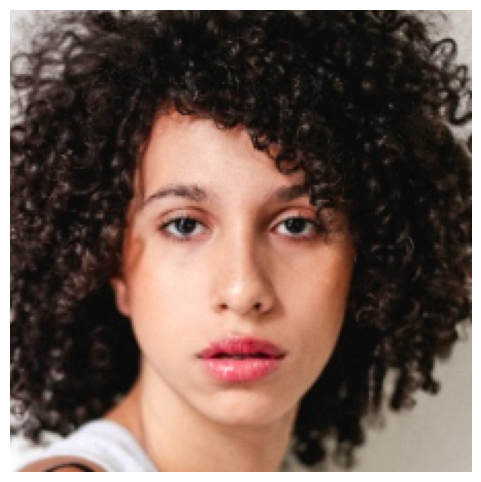

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(real_images_raw[1], vmin=-5, vmax=11)
plt.axis('off')
plt.show()

# Creating dataloaders

In [ ]:
batch_size = 32  # both for training and testing

Spec Images:

In [ ]:
train_loader_spec = DataLoader(train_dataset_spec, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader_spec = DataLoader(test_dataset_spec, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {0: "synthetic", 1: "real"}

Raw Images:

In [ ]:
train_loader_raw = DataLoader(train_dataset_raw, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_raw = DataLoader(test_dataset_raw, batch_size=batch_size, shuffle=False, drop_last=True)

# Map from class index to class name.
classes = {0: "synthetic", 1: "real"}

Clip Images:

In [ ]:
train_images_clip = torch.tensor(train_images_clip, dtype=torch.float32).cuda()
train_labels_clip = torch.tensor(train_labels_clip, dtype=torch.long).cuda()
test_images_clip = torch.tensor(test_images_clip, dtype=torch.float32).cuda()
test_labels_clip = torch.tensor(test_labels_clip, dtype=torch.long).cuda()


train_dataset_clip = TensorDataset(train_images_clip, train_labels_clip)
test_dataset_clip = TensorDataset(test_images_clip, test_labels_clip)
train_loader_clip = DataLoader(train_dataset_clip, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_clip = DataLoader(test_dataset_clip, batch_size=batch_size, shuffle=False, drop_last=True)

<ipython-input-66-5b8a0eed9944>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_images_clip = torch.tensor(train_images_clip, dtype=torch.float32).cuda()
<ipython-input-66-5b8a0eed9944>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_images_clip = torch.tensor(test_images_clip, dtype=torch.float32).cuda()


In [ ]:
print("Training data spec")
print("Number of points:", len(train_dataset_spec))


x, y = next(iter(train_loader_spec))
print("Batch dimension (B x C x H x W):", x.shape)

train_labels = [label for _, label in train_dataset_spec]
print(f"Number of distinct labels: {len(set(train_labels))} (unique labels: {set(train_labels)})")

print("\nTest data spec")
print("Number of points:", len(test_dataset_spec))

x, y = next(iter(test_loader_spec))
print("Batch dimension (B x C x H x W):", x.shape)

test_labels_spec = [label for _, label in test_dataset_spec]
print(f"Number of distinct labels: {len(set(test_labels_spec))} (unique labels: {set(test_labels_spec)})")

n_classes = len(set(test_labels_spec))


Training data spec
Number of points: 14592
Batch dimension (B x C x H x W): torch.Size([32, 1, 224, 224])
Number of distinct labels: 2 (unique labels: {0, 1})

Test data spec
Number of points: 3648
Batch dimension (B x C x H x W): torch.Size([32, 1, 224, 224])
Number of distinct labels: 2 (unique labels: {0, 1})


In [ ]:
print("Training data raw")
print("Number of points:", len(train_dataset_raw))


x, y = next(iter(train_loader_raw))
print("Batch dimension (B x C x H x W):", x.shape)

train_labels = [label for _, label in train_dataset_raw]
print(f"Number of distinct labels: {len(set(train_labels))} (unique labels: {set(train_labels)})")

print("\nTest data spec")
print("Number of points:", len(test_dataset_raw))

x, y = next(iter(test_loader_raw))
print("Batch dimension (B x C x H x W):", x.shape)

test_labels_raw = [label for _, label in test_dataset_raw]
print(f"Number of distinct labels: {len(set(test_labels_raw))} (unique labels: {set(test_labels_raw)})")

n_classes = len(set(test_labels_raw))

Training data raw
Number of points: 14592
Batch dimension (B x C x H x W): torch.Size([32, 3, 224, 224])
Number of distinct labels: 2 (unique labels: {0, 1})

Test data spec
Number of points: 3648
Batch dimension (B x C x H x W): torch.Size([32, 3, 224, 224])
Number of distinct labels: 2 (unique labels: {0, 1})


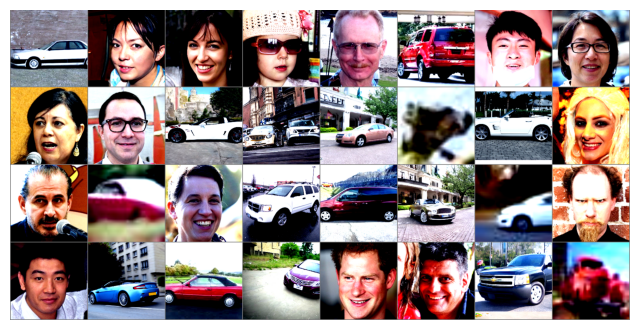

In [ ]:
images_raw, labels_raw = next(iter(train_loader_raw))
show_image(torchvision.utils.make_grid(images_raw))

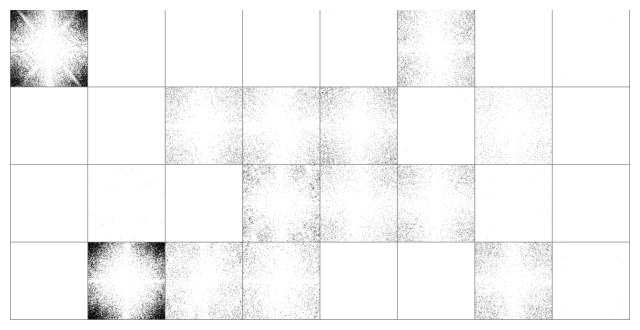

In [ ]:
images_spec, labels_spec = next(iter(train_loader_spec))
show_image(torchvision.utils.make_grid(images_spec))

In [ ]:
class PrintSize(nn.Module):

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

n_classes = 100

class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        activation_fn = nn.ReLU

        self.num_classes = num_classes

        self.net_spec = nn.Sequential(

            # 1. conv layer:
            PrintSize(),
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            activation_fn(),

            # 2. conv layer:
            PrintSize(),
            nn.Conv2d(32, 32, 5, stride = 1, padding=(2, 2)),
            nn.BatchNorm2d(32),
            activation_fn(),


            #Maxpool:
            PrintSize(),
            nn.MaxPool2d(2,stride = 2),

            # 3. conv layer:
            nn.Conv2d(32, 32, 3, stride = 1, padding=(1, 1)),

            #Dropout:
            nn.Dropout2d(p=0.25),

            #Flatten:
            nn.Flatten(),  # from (1, channels, height, width) to (1, channels * height * width)
            PrintSize(),


            nn.Linear(401408, 256),
            nn.BatchNorm1d(256),
            nn.Dropout1d(p=0.1),
            activation_fn(),
            PrintSize(),

            # 1. Dense layer
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            activation_fn(),
            PrintSize(),

            # 2. Dense layer
            nn.Linear(128, num_classes),
            PrintSize(),


        )
        # Model for raw images:
        self.model_raw = resnet18(pretrained=True)

        # Model for clip:
        self.model_clip = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )


        # Combined features output layer
        self.final_out = nn.Linear(128 + num_classes + num_classes, 2)

        self.reduce_resnet = nn.Sequential(nn.Linear(1000, 128),nn.BatchNorm1d(128),nn.ReLU())

    def forward(self, x_spec, x_raw, x_clip):

        model_raw_out = self.model_raw(x_raw)

        model_spec_out = self.net_spec(x_spec)

        reduced_raw_out = self.reduce_resnet(model_raw_out)

        model_clip_out = self.model_clip(x_clip)

        ##### Combined features #####

        combined_features = torch.cat((reduced_raw_out, model_spec_out, model_clip_out), dim=1)

        out = self.final_out(combined_features)

        return out


model = Model(n_classes)
device = torch.device('cuda')  # use cuda or cpu
model.to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


Model(
  (net_spec): Sequential(
    (0): PrintSize()
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): PrintSize()
    (5): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): PrintSize()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Dropout2d(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): PrintSize()
    (14): Linear(in_features=401408, out_features=256, bias=True)
    (15): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Dropout1d(p=0.1, inplace=False)
    (17): ReLU()
    (18): PrintSize()
    (19): Linear(in_features=256, out_f

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.002)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

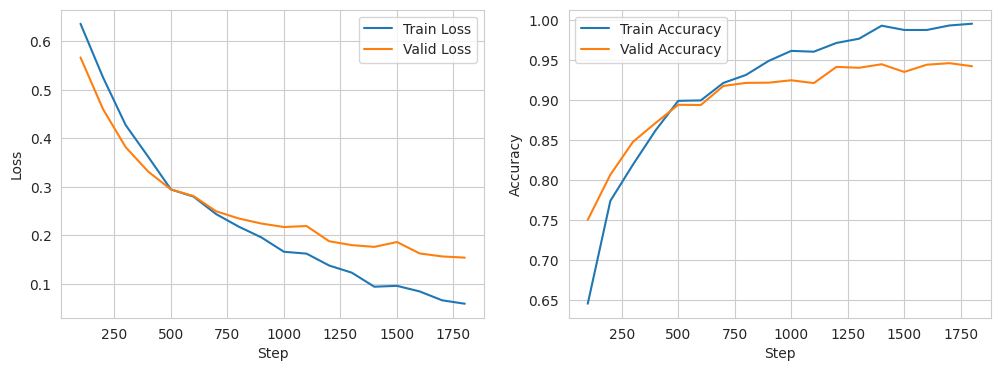

In [ ]:
num_epochs = 4
validation_every_steps = 100

# Tracking variables
step = 0
model.train()
train_accuracies = []
valid_accuracies = []
train_losses = []
valid_losses = []
train_iters = []
valid_iters = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training metrics per epoch
    train_accuracies_batches = []
    train_loss_batches = []

    # Combine datasets using zip
    for (inputs_spec, targets_spec), (inputs_raw, targets_raw), (inputs_clip, targets_clip) in zip(train_loader_spec, train_loader_raw, train_loader_clip):
        # Move targets to the appropriate device
        targets_spec = targets_spec.to(device)
        targets_raw = targets_raw.to(device)
        targets_clip = targets_clip.to(device)

        # Ensure the targets match in all loaders
        assert torch.equal(targets_spec, targets_raw), "Mismatched targets between spec and raw loaders!"
        assert torch.equal(targets_spec, targets_clip), "Mismatched targets between spec and clip loaders!"

        # Move data to the appropriate device
        inputs_spec = inputs_spec.float().to(device)
        inputs_raw = inputs_raw.to(device)
        inputs_clip = inputs_clip.to(device)

        # Forward pass
        output = model(inputs_spec, inputs_raw, inputs_clip)
        loss = loss_fn(output, targets_spec)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute and track training loss and accuracy
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets_spec, predictions))
        train_loss_batches.append(loss.item())

        # Validation logic
        if step % validation_every_steps == 0:
            # Append average training metrics
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_losses.append(np.mean(train_loss_batches))
            train_iters.append(step)
            train_accuracies_batches = []
            train_loss_batches = []

            # Compute validation metrics
            valid_accuracies_batches = []
            valid_loss_batches = []

            with torch.no_grad():
                model.eval()
                for (val_inputs_spec, val_targets_spec), (val_inputs_raw, val_targets_raw), (val_inputs_clip, val_targets_clip) in zip(test_loader_spec, test_loader_raw, test_loader_clip):
                    # Move validation targets to the appropriate device
                    val_targets_spec = val_targets_spec.to(device)
                    val_targets_raw = val_targets_raw.to(device)
                    val_targets_clip = val_targets_clip.to(device)

                    # Ensure the targets match in all loaders
                    assert torch.equal(val_targets_spec, val_targets_raw), "Mismatched targets between spec and raw validation loaders!"
                    assert torch.equal(val_targets_spec, val_targets_clip), "Mismatched targets between spec and clip validation loaders!"

                    # Move data to the appropriate device
                    val_inputs_spec = val_inputs_spec.float().to(device)
                    val_inputs_raw = val_inputs_raw.to(device)
                    val_inputs_clip = val_inputs_clip.to(device)

                    # Forward pass
                    val_output = model(val_inputs_spec, val_inputs_raw, val_inputs_clip)
                    val_loss = loss_fn(val_output, val_targets_spec)

                    # Compute metrics
                    val_predictions = val_output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(val_targets_spec, val_predictions) * len(val_inputs_spec))
                    valid_loss_batches.append(val_loss.item() * len(val_inputs_spec))

                # Calculate average validation metrics
                valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_loader_spec.dataset))
                valid_losses.append(np.sum(valid_loss_batches) / len(test_loader_spec.dataset))
                valid_iters.append(step)

            # Switch back to training mode
            model.train()

            # Print current metrics
            print(f"Step {step:<5} - Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.4f}")
            print(f"Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}")

    # Plot progress after each epoch
    clear_output(wait=True)
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_iters, train_losses, label="Train Loss")
    plt.plot(valid_iters, valid_losses, label="Valid Loss")
    plt.legend()
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(train_iters, train_accuracies, label="Train Accuracy")
    plt.plot(valid_iters, valid_accuracies, label="Valid Accuracy")
    plt.legend()
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.show()


Evaluating on Both Datasets...
Sample Images from Specific Dataset:


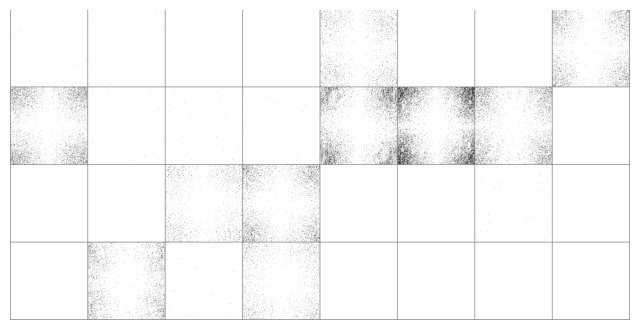

Sample Images from Raw Dataset:


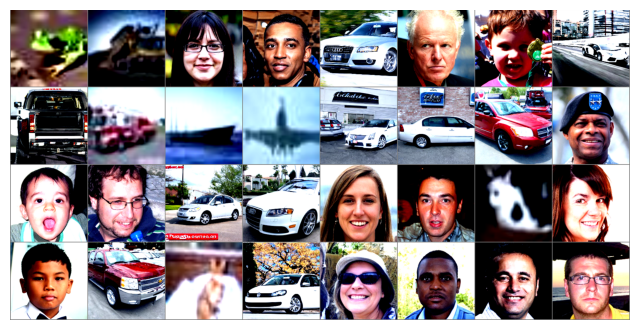

    TRUE        PREDICTED (Both Datasets)
-----------------------------
  synthetic     synthetic  
  synthetic     synthetic  
  synthetic     synthetic  
  synthetic     synthetic  
  synthetic     synthetic  
    real          real     
    real          real     
  synthetic     synthetic  
  synthetic     synthetic  
    real          real     
  synthetic       real     
    real          real     
  synthetic     synthetic  
  synthetic     synthetic  
  synthetic     synthetic  
    real        synthetic  
    real          real     
    real          real     
  synthetic     synthetic  
  synthetic     synthetic  
  synthetic     synthetic  
  synthetic     synthetic  
    real          real     
    real          real     
    real          real     
  synthetic     synthetic  
    real          real     
  synthetic     synthetic  
  synthetic     synthetic  
  synthetic     synthetic  
    real          real     
    real          real     




In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Iterate over both test datasets
for (test_loader_spec, test_loader_raw, test_loader_clip), dataset_name in [
    ((test_loader_spec, test_loader_raw, test_loader_clip), "Both Datasets"),
]:
    print(f"Evaluating on {dataset_name}...")

    # Get inputs and targets from all loaders
    inputs_spec, targets_spec = next(iter(test_loader_spec))
    inputs_raw, targets_raw = next(iter(test_loader_raw))
    inputs_clip, targets_clip = next(iter(test_loader_clip))

    # Move data to the appropriate device
    inputs_spec, inputs_raw = inputs_spec.to(device), inputs_raw.to(device)
    targets_spec, targets_raw = targets_spec.to(device), targets_raw.to(device)
    inputs_clip, targets_clip = inputs_clip.to(device), targets_clip.to(device)

    # Ensure the targets match between datasets
    assert torch.equal(targets_spec, targets_raw), "Mismatched targets between spec and raw loaders!"
    assert torch.equal(targets_spec, targets_clip), "Mismatched targets between spec and clip loaders!"

    # Visualize the inputs from the first dataset (or both if desired)
    print("Sample Images from Specific Dataset:")
    show_image(make_grid(inputs_spec))  # Assuming show_image is defined to display images
    plt.show()

    print("Sample Images from Raw Dataset:")
    show_image(make_grid(inputs_raw))
    plt.show()

    # Forward pass through the ensemble model
    outputs = model(inputs_spec, inputs_raw, inputs_clip)
    _, predicted = torch.max(outputs.data, 1)

    # Display true and predicted classes
    print(f"    TRUE        PREDICTED ({dataset_name})")
    print("-" * 29)
    for target, pred in zip(targets_spec, predicted):
        print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")
    print("\n")


In [ ]:
def compute_confusion_matrix(targets, predictions, n_classes):
    """
    Computes a confusion matrix for a given set of targets and predictions.

    Parameters:
        targets (Tensor): Ground truth labels.
        predictions (Tensor): Predicted labels.
        n_classes (int): Number of classes.

    Returns:
        np.ndarray: Confusion matrix of shape (n_classes, n_classes).
    """
    # Convert PyTorch tensors to NumPy arrays
    targets_np = targets.cpu().numpy()
    predictions_np = predictions.cpu().numpy()

    # Compute confusion matrix without normalization
    cm = sklearn_confusion_matrix(targets_np, predictions_np, labels=np.arange(n_classes))
    return cm


In [ ]:
# Set the correct number of classes
n_classes = 2  # Adjust based on your dataset
confusion_matrix = np.zeros((n_classes, n_classes))

with torch.no_grad():
    model.eval()
    test_accuracies = []

    for (inputs_spec, targets_spec), (inputs_raw, targets_raw), (inputs_clip, targets_clip) in zip(test_loader_spec, test_loader_raw, test_loader_clip):
        inputs_spec, inputs_raw, inputs_clip = inputs_spec.to(device), inputs_raw.to(device), inputs_clip.to(device)
        targets_spec, targets_raw, targets_clip = targets_spec.to(device), targets_raw.to(device), targets_clip.to(device)

        assert torch.equal(targets_spec, targets_raw), "Mismatched targets between loaders!"

        outputs = model(inputs_spec, inputs_raw, inputs_clip)
        predictions = outputs.max(1)[1]

        test_accuracies.append(accuracy(targets_spec, predictions) * len(inputs_spec))

        # Update confusion matrix
        confusion_matrix += compute_confusion_matrix(targets_spec, predictions, n_classes)

    test_accuracy = np.sum(test_accuracies) / len(test_loader_spec.dataset)

    model.train()

# Print results
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix)


Test Accuracy: 0.9498
Confusion Matrix:
[[1725.   99.]
 [  84. 1740.]]


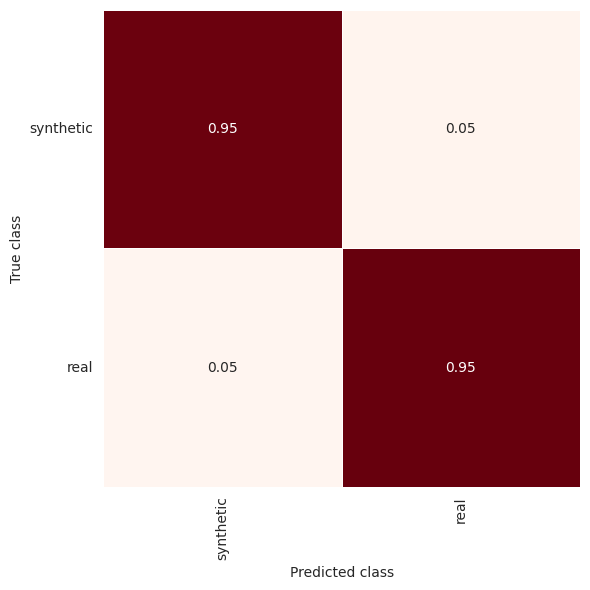

In [ ]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

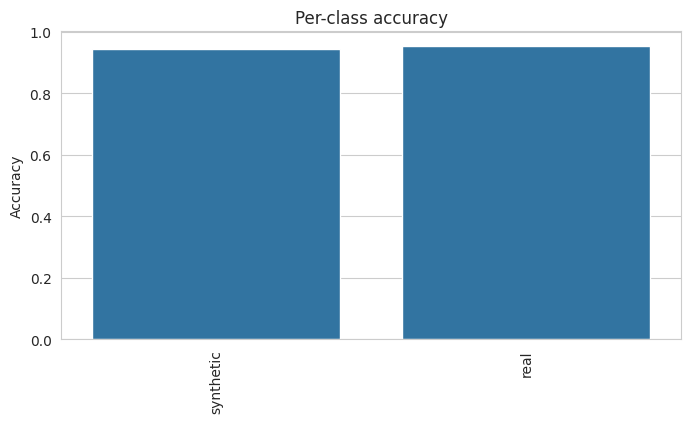

In [ ]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

In [ ]:
for i, ((inputs_spec, targets_spec), (inputs_raw, targets_raw)) in enumerate(zip(train_loader_spec, train_loader_raw)):
    if not torch.equal(targets_spec, targets_raw):
        print(f"Mismatch in batch {i}:")
        print(f"targets_spec: {targets_spec}")
        print(f"targets_raw: {targets_raw}")
        break


In [ ]:
 # Load the data from a pickle file of self made images

path = '/content/drive/MyDrive/Colab Notebooks/DL_Project/'
with open(path + '/standford_cars_self_made_spec_pickle.pickle', 'rb') as f:
     self_made_images_spec = pickle.load(f)

In [ ]:
 # Load the data from a pickle file of self made images

path = '/content/drive/MyDrive/Colab Notebooks/DL_Project/'
with open(path + '/standford_cars_self_made_CLIP_embedded_pickle.pickle', 'rb') as f:
     self_made_images_clip = pickle.load(f)

In [ ]:
 # Load the data from a pickle file of self-made images

path = '/content/drive/MyDrive/Colab Notebooks/DL_Project/'
with open(path + '/self_made_cars_preprocessed_images.pickle', 'rb') as f:
     self_made_images_raw = pickle.load(f)

In [ ]:
self_made_labels = [0] * len(self_made_images_spec)  # Label 0 for synthetic images

In [ ]:
# Define transformation
transform_spec = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Apply transformation when creating datasets
test_dataset_spec_self_made = [(transform_spec(image).float(), label) for image, label in zip(self_made_images_spec, self_made_labels)]



In [ ]:
transform_raw = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create datasets
test_dataset_raw_self_made = ImageDataset(self_made_images_raw, self_made_labels, transform=transform_raw)

In [ ]:
batch_size = 22  # both for training and testing

In [ ]:
self_made_loader_spec = DataLoader(test_dataset_spec_self_made, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {0: "synthetic", 1: "real"}

In [ ]:
self_made_loader_raw = DataLoader(test_dataset_raw_self_made, batch_size=batch_size, shuffle=False, drop_last=True)

# Map from class index to class name.
classes = {0: "synthetic", 1: "real"}

In [ ]:
# Ensure self_made_labels is converted to a tensor
self_made_images_clip = torch.tensor(self_made_images_clip, dtype=torch.float32).cuda()
self_made_labels_clip = torch.tensor(self_made_labels, dtype=torch.long).cuda()

# Create a TensorDataset with tensors
self_made_dataset_clip = TensorDataset(self_made_images_clip, self_made_labels_clip)
self_made_loader_clip = DataLoader(self_made_dataset_clip, batch_size=batch_size, shuffle=False, drop_last=True)


<ipython-input-90-f8f0edf11fbb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self_made_images_clip = torch.tensor(self_made_images_clip, dtype=torch.float32).cuda()


Evaluating on Both Datasets...
Sample Images from Specific Dataset:


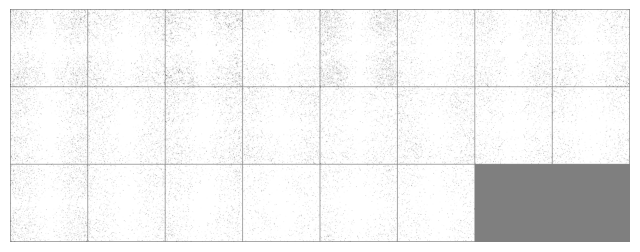

Sample Images from Raw Dataset:


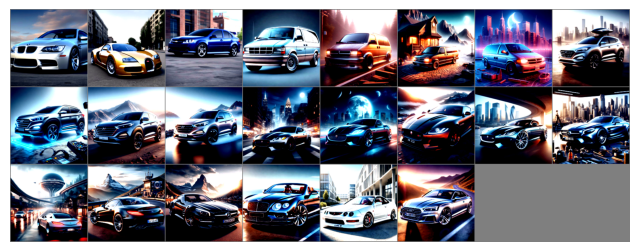

    TRUE        PREDICTED (Both Datasets)
-----------------------------
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic     synthetic  
  synthetic     synthetic  
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     
  synthetic       real     




In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Iterate over both test datasets
for (self_made_loader_spec, self_made_loader_raw, self_made_loader_clip), dataset_name in [
    ((self_made_loader_spec, self_made_loader_raw, self_made_loader_clip), "Both Datasets"),
]:
    print(f"Evaluating on {dataset_name}...")

    inputs_spec, targets_spec = next(iter(self_made_loader_spec))
    inputs_raw, targets_raw = next(iter(self_made_loader_raw))
    inputs_clip, targets_clip = next(iter(self_made_loader_clip))

    inputs_spec, inputs_raw = inputs_spec.to(device), inputs_raw.to(device)
    targets_spec, targets_raw = targets_spec.to(device), targets_raw.to(device)
    inputs_clip, targets_clip = inputs_clip.to(device), targets_clip.to(device)


    assert torch.equal(targets_spec, targets_raw), "Mismatched targets between spec and raw loaders!"
    assert torch.equal(targets_spec, targets_clip), "Mismatched targets between spec and clip loaders!"


    print("Sample Images from Specific Dataset:")
    show_image(make_grid(inputs_spec))
    plt.show()

    print("Sample Images from Raw Dataset:")
    show_image(make_grid(inputs_raw))
    plt.show()


    outputs = model(inputs_spec, inputs_raw, inputs_clip)
    _, predicted = torch.max(outputs.data, 1)

    print(f"    TRUE        PREDICTED ({dataset_name})")
    print("-" * 29)
    for target, pred in zip(targets_spec, predicted):
        print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")
    print("\n")
